In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../Pyfiles')
# Pull in the helper files.
from ImageRead import *
from QNN import *


# Image QNN Training
Saesun Kim

First we import the data


In [2]:
target_o = [0 for i in range(25)]+[1 for i in range(25)]

In [13]:
pathY=r'..\\dataset\\Original\\storm\\'
pathN=r'..\\dataset\\Original\\No-storm\\'
nameN='no_storm'
nameY='storm'
inputY=[imageResize(callImage(i+1,pathY,nameY),8) for i in range(25)]
inputN=[imageResize(callImage(i+1,pathN,nameN),8) for i in range(25)]
input_combine = inputY+inputN

In [15]:
np.random.seed(0)
idx=np.array([int(i) for i in range(50)]).flatten()

np.random.shuffle(idx)

dataInput = list(input_combine[i] for i in idx )
dataTarget = list( imageBinarize(input_combine[i]) for i in idx )

data_target_o=list( target_o[i] for i in idx )

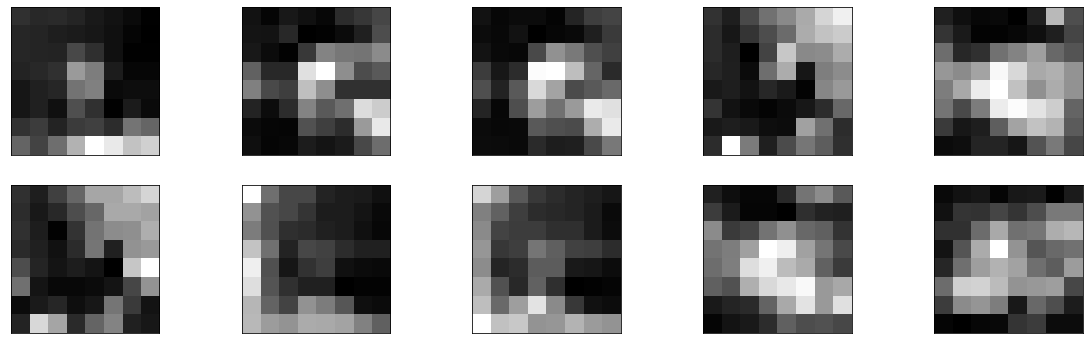

In [16]:
n_samples_show = 5
fig, axes = plt.subplots(nrows=2, ncols=n_samples_show, figsize=(20, 6))

for i in range(n_samples_show):

    axes[0,i].imshow(dataInput[i], cmap='gray')
    axes[0,i].set_xticks([])
    axes[0,i].set_yticks([])
    axes[1,i].imshow(dataInput[i+5], cmap='gray')
    axes[1,i].set_xticks([])
    axes[1,i].set_yticks([])    


In [17]:
Xtest= [normlaizeData(dataInput[i+15].flatten()) for i in range(10)]
y01test= [data_target_o[i+15] for i in range(10)]

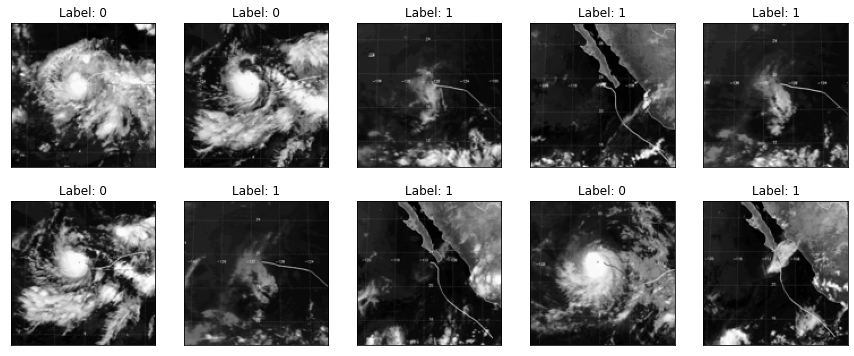

In [7]:
n_samples_show = 5
fig, axes = plt.subplots(nrows=2, ncols=n_samples_show, figsize=(15, 6))

for i in range(5):
    axes[0,i].imshow(np.array(np.array_split(Xtest[i], 128)), cmap='gray')
    axes[0,i].set_xticks([])
    axes[0,i].set_yticks([])
    axes[0,i].set_title("Label: {}".format(y01test[i]))
    axes[1,i].imshow(np.array(np.array_split(Xtest[i+5], 128)), cmap='gray')
    axes[1,i].set_xticks([])
    axes[1,i].set_yticks([])
    axes[1,i].set_title("Label: {}".format(y01test[i+5]))    

# Parameterized Quantum Circuit

## Here is the converged QNN

In [19]:
from qiskit.circuit.parameter import Parameter
from qiskit_machine_learning.neural_networks import CircuitQNN
from qiskit_machine_learning.connectors import TorchConnector
from qiskit.utils import QuantumInstance
from torch.nn import Linear, CrossEntropyLoss, MSELoss
from torch.optim import LBFGS, SGD,Adam 
qi = QuantumInstance(Aer.get_backend('statevector_simulator'))
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B

# Model for LBFGS
# Combining the circuit together with CircuitQNN
np.random.seed(3)


nqubits=6
num_inputs=2**nqubits
qc = QuantumCircuit(nqubits)

# Encoding
param_x=[];
for i in range(2**nqubits):
    param_x.append(Parameter('x'+str(i)))
for i in range(8):
    param_x.append(np.pi/2)


feature_map = encoding(qc,param_x,6)


# Optimzing circuit PQC
param_y=[];
for i in range(nqubits*2):
    param_y.append(Parameter('θ'+str(i)))

ansatz=circuit15(qc,param_y)

qc.append(feature_map, range(nqubits))
qc.append(ansatz, range(nqubits))

qnn2 = CircuitQNN(qc, input_params=feature_map.parameters, weight_params=ansatz.parameters, 
                  interpret=parity, output_shape=2, quantum_instance=qi)
initial_weights = 0.1*(2*np.random.rand(qnn2.num_weights) - 1)


In [21]:
# define optimizer and loss function

model2 = TorchConnector(qnn2, initial_weights)

optimizer = LBFGS(model2.parameters(),lr=0.1)
f_loss = CrossEntropyLoss()

X= [normlaizeData(dataInput[i].flatten()) for i in range(15)]
y01= [data_target_o[i] for i in range(15)]

In [41]:
# traning model accuracy
y_predict = []
for x in X:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print('Accuracy:', sum(y_predict == np.array(y01))/len(np.array(y01)))

Accuracy: 0.8666666666666667


In [42]:
# Test nidek accuracy

Xtest= [normlaizeData(dataInput[i+15].flatten()) for i in range(10)]
y01test= [data_target_o[i+15] for i in range(10)]

y_predict = []
for x in Xtest:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print('Accuracy:', sum(y_predict == np.array(y01test))/len(np.array(y01test)))

Accuracy: 0.9


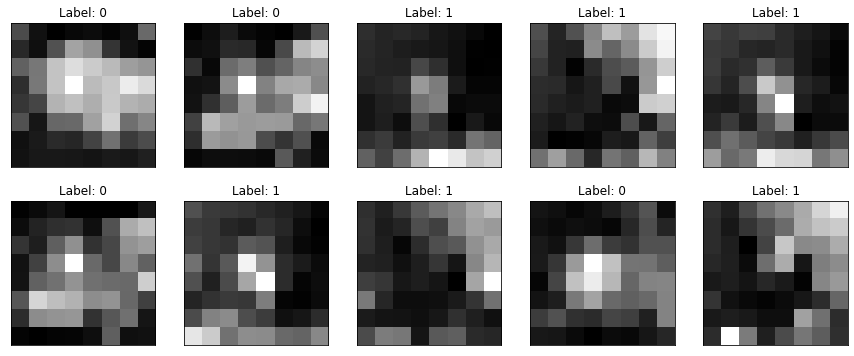

In [49]:
n_samples_show = 5
fig, axes = plt.subplots(nrows=2, ncols=n_samples_show, figsize=(15, 6))

for i in range(5):
    axes[0,i].imshow(np.array(np.array_split(Xtest[i], 8)), cmap='gray')
    axes[0,i].set_xticks([])
    axes[0,i].set_yticks([])
    axes[0,i].set_title("Label: {}".format(y01test[i]))
    axes[1,i].imshow(np.array(np.array_split(Xtest[i+5], 8)), cmap='gray')
    axes[1,i].set_xticks([])
    axes[1,i].set_yticks([])
    axes[1,i].set_title("Label: {}".format(y01test[i+5]))    

In [191]:
from qiskit_machine_learning.neural_networks import CircuitQNN
from qiskit_machine_learning.connectors import TorchConnector
from qiskit.utils import QuantumInstance
from torch.nn import Linear, CrossEntropyLoss, MSELoss
from torch.optim import LBFGS, SGD,Adam 
qi = QuantumInstance(Aer.get_backend('statevector_simulator'))
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B

# Model for LBFGS
# Combining the circuit together with CircuitQNN
np.random.seed(3)


nqubits=6
num_inputs=2**nqubits
qc = QuantumCircuit(nqubits)

param_x=[];
for i in range(2**nqubits):
    param_x.append(Parameter('x'+str(i)))
for i in range(8):
    param_x.append(np.pi/2)

feature_map = encoding(qr,param_x,6)

param_y=[];
for i in range(nqubits*2):
    param_y.append(Parameter('θ'+str(i)))

ansatz=circuit15(qr,param_y)

qc.append(feature_map, range(nqubits))
qc.append(ansatz, range(nqubits))

qnn2 = CircuitQNN(qc, input_params=feature_map.parameters, weight_params=ansatz.parameters, 
                  interpret=parity, output_shape=2, quantum_instance=qi)
initial_weights = 0.1*(2*np.random.rand(qnn2.num_weights) - 1)


# Learning Rate 0.1

In [229]:
# define optimizer and loss function

model2 = TorchConnector(qnn2, initial_weights)

optimizer = LBFGS(model2.parameters(),lr=0.1)
f_loss = CrossEntropyLoss()

X= [normlaizeData(dataInput[i].flatten()) for i in range(15)]
y01= [data_target_o[i] for i in range(15)]

In [201]:
from torch import Tensor
# start training

model2.train()    # set model to training mode

# define objective function
def closure():
    optimizer.zero_grad()                                  # initialize gradient
    loss = 0.0                                             # initialize loss    
    for x, y_target in zip(X, y01):                        # evaluate batch loss
        output = model2(Tensor(x)).reshape(1, 2)           # forward pass
        loss += f_loss(output, Tensor([y_target]).long())
    loss.backward()                                        # backward pass
    print(loss.item())                                     # print loss
    return loss

# run optimizer
optimizer.step(closure)

10.976895332336426
10.95108413696289
10.92065143585205
10.88494873046875
10.843300819396973
10.795140266418457
10.740145683288574
10.678409576416016
10.610583305358887
10.537991523742676
10.462610244750977
10.386885643005371
9.922740936279297
9.913456916809082
9.903972625732422
9.89436149597168
9.884696960449219
10.193254470825195
10.285778045654297
10.189127922058105


tensor(10.9769, grad_fn=<AddBackward0>)

In [202]:
# traning model accuracy
y_predict = []
for x in X:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print('Accuracy:', sum(y_predict == np.array(y01))/len(np.array(y01)))

Accuracy: 0.8666666666666667


In [203]:
# Test nidek accuracy

Xtest= [normlaizeData(dataInput[i+15].flatten()) for i in range(10)]
y01test= [data_target_o[i+15] for i in range(10)]

y_predict = []
for x in Xtest:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print('Accuracy:', sum(y_predict == np.array(y01test))/len(np.array(y01test)))

Accuracy: 0.9


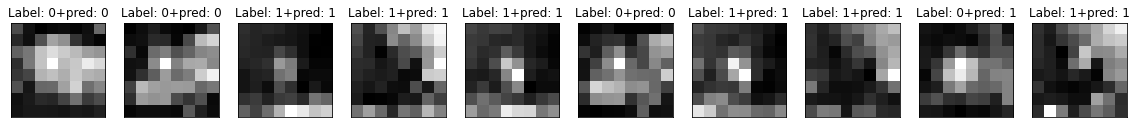

In [204]:
n_samples_show = 10
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(20, 3))

for i in range(10):
    axes[i].imshow(np.array(np.array_split(Xtest[i], 8)), cmap='gray')
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].set_title("Label: {}".format(y01test[i])+"+pred: {}".format(y_predict[i]))

# Learning rate 0.01

In [210]:
# define optimizer and loss function

model2 = TorchConnector(qnn2, initial_weights)

optimizer = LBFGS(model2.parameters(),lr=0.01)
f_loss = CrossEntropyLoss()

X= [normlaizeData(dataInput[i].flatten()) for i in range(15)]
y01= [data_target_o[i] for i in range(15)]

In [211]:
from torch import Tensor
# start training

model2.train()    # set model to training mode

# define objective function
def closure():
    optimizer.zero_grad()                                  # initialize gradient
    loss = 0.0                                             # initialize loss    
    for x, y_target in zip(X, y01):                        # evaluate batch loss
        output = model2(Tensor(x)).reshape(1, 2)           # forward pass
        loss += f_loss(output, Tensor([y_target]).long())
    loss.backward()                                        # backward pass
    print(loss.item())                                     # print loss
    return loss

# run optimizer
optimizer.step(closure)

10.976895332336426
10.974409103393555
10.97187328338623
10.969293594360352
10.966669082641602
10.96399974822998
10.961284637451172
10.958521842956543
10.955713272094727
10.952855110168457
10.949950218200684
10.946993827819824
10.943984985351562
10.940926551818848
10.937816619873047
10.934653282165527
10.931434631347656
10.928163528442383
10.924835205078125
10.921452522277832


tensor(10.9769, grad_fn=<AddBackward0>)

In [212]:
# traning model accuracy
y_predict = []
for x in X:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print('Accuracy:', sum(y_predict == np.array(y01))/len(np.array(y01)))

Accuracy: 0.6


In [213]:
# Test nidek accuracy

Xtest= [normlaizeData(dataInput[i+15].flatten()) for i in range(10)]
y01test= [data_target_o[i+15] for i in range(10)]

y_predict = []
for x in Xtest:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print('Accuracy:', sum(y_predict == np.array(y01test))/len(np.array(y01test)))

Accuracy: 0.6


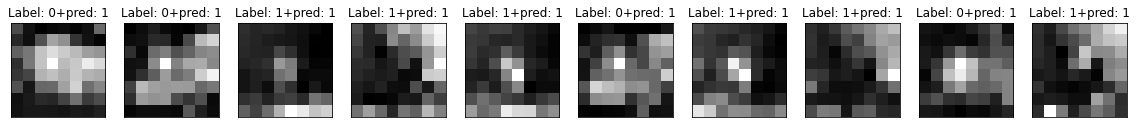

In [214]:
n_samples_show = 10
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(20, 3))

for i in range(10):
    axes[i].imshow(np.array(np.array_split(Xtest[i], 8)), cmap='gray')
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].set_title("Label: {}".format(y01test[i])+"+pred: {}".format(y_predict[i]))